# Mono-Objective Linear Optimization Problems for Sales Territory Assignment

$$\text{Idriss MORTADI} - \text{Abdellah OUMIDA} - \text{Abdelaziz GUELFANE}$$

## Minimizing Total Travel Distance

**Objective**: Minimize the total travel distance traveled by all SRs within their assigned territories.

**Decision Variables**:
- $x_{ij}$: Binary variable, $x_{ij} = 1$ if brick $j$ is assigned to SR $i$, $x_{ij} = 0$ otherwise.

**Parameters**:
- $d_{ij}$: Distance between SR $i$'s center and brick $j$.
- $w_j$: Workload (index value) of brick $j$.

**Formulation**:
$$
\text{Minimize: } \sum_{i=1}^{n} \sum_{j=1}^{m} d_{ij} \cdot x_{ij}
$$

**Subject to**:

1. **Workload Balance**:
   $$
   0.8 \leq \sum_{j=1}^{m} w_j \cdot x_{ij} \leq 1.2 \quad \forall i
   $$
2. **Assignment of Bricks**:
   $$
   \sum_{i=1}^{n} x_{ij} = 1 \quad \forall j
   $$
3. **Binary Decision Variables**:
   $$
   x_{ij} \in \{0, 1\} \quad \forall i, j
   $$

4. **Fixed SR Positions**:
   $$
   x_{1,4} = 1 \quad \text{(SR1 is fixed at brick 4)}
   $$
   $$
   x_{2,14} = 1 \quad \text{(SR2 is fixed at brick 14)}
   $$
   $$
   x_{3,16} = 1 \quad \text{(SR3 is fixed at brick 16)}
   $$
   $$
   x_{4,22} = 1 \quad \text{(SR4 is fixed at brick 22)}
   $$

## Minimizing Disruption

**Objective**: Minimize the disruption caused by reassigning bricks to different SRs, weighted by the workload (index value) of the disrupted bricks.

**Decision Variables**:
- $x_{ij}$: Binary variable as defined above.

**Parameters**:
- $c_{ij}$: Binary constant, $c_{ij} = 1$ if brick $j$ is currently assigned to SR $i$, $c_{ij} = 0$ otherwise.
- $w_j$: Workload (index value) of brick $j$.

**Formulation**:
$$
\text{Minimize: } \sum_{i=1}^{n} \sum_{j=1}^{m} w_j \cdot (1 - c_{ij}) \cdot x_{ij}
$$

**Subject to**:

1. **Workload Balance**:
   $$
   0.8 \leq \sum_{j=1}^{m} w_j \cdot x_{ij} \leq 1.2 \quad \forall i
   $$
2. **Assignment of Bricks**:
   $$
   \sum_{i=1}^{n} x_{ij} = 1 \quad \forall j
   $$
3. **Binary Decision Variables**:
   $$
   x_{ij} \in \{0, 1\} \quad \forall i, j
   $$

4. **Fixed SR Positions Centers**:
   $$
   x_{1,4} = 1 \quad \text{(SR1 is fixed at brick 4)}
   $$
   $$
   x_{2,14} = 1 \quad \text{(SR2 is fixed at brick 14)}
   $$
   $$
   x_{3,16} = 1 \quad \text{(SR3 is fixed at brick 16)}
   $$
   $$
   x_{4,22} = 1 \quad \text{(SR4 is fixed at brick 22)}
   $$

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum


n = 4  
m = 22  


def load_data():
    
    df = pd.read_csv("brick_rp_distances.csv", sep=",")
    distances = df.values[:, 1:].T  

    
    workloads_df = pd.read_csv("bricks_index_values.csv")
    workloads = workloads_df.values[:, 1]  
    
    return distances, workloads


def initialize_assigned_bricks():
    
    assigned_bricks = {
        1: [4, 5, 6, 7, 8, 15],
        2: [10, 11, 12, 13, 14],
        3: [9, 16, 17, 18],
        4: [1, 2, 3, 19, 20, 21, 22]
    }

    
    assigned_matrix = np.zeros((len(assigned_bricks), m), dtype=int)

    
    for sr_index, bricks in assigned_bricks.items():
        for brick in bricks:
            assigned_matrix[sr_index - 1, brick - 1] = 1

    return assigned_matrix, assigned_bricks


def set_workload_limits(workloads, workload_lower, workload_upper):
    total_workload = sum(workloads)
    min_workload = workload_lower * (total_workload / n)
    max_workload = workload_upper * (total_workload / n)
    
    return min_workload, max_workload


def add_common_constraints(model, assignment_vars, workloads, min_workload, max_workload):
    for sr in range(n):
        model.addConstr(
            quicksum(workloads[brick] * assignment_vars[sr, brick] for brick in range(m)) >= min_workload
        )
        model.addConstr(
            quicksum(workloads[brick] * assignment_vars[sr, brick] for brick in range(m)) <= max_workload
        )

    for brick in range(m):
        model.addConstr(
            quicksum(assignment_vars[sr, brick] for sr in range(n)) == 1
        )

    model.addConstr(assignment_vars[0, 3] == 1)
    model.addConstr(assignment_vars[1, 13] == 1)
    model.addConstr(assignment_vars[2, 15] == 1)
    model.addConstr(assignment_vars[3, 21] == 1)


def solve_minimize_travel_distance(distances, workloads, assigned_matrix, min_workload, max_workload):
    model = Model("Minimize_Travel_Distance")
    model.setParam('OutputFlag', 0)  
    
    assignment_vars = model.addVars(n, m, vtype=GRB.BINARY, name="x")

    
    model.setObjective(
        quicksum(distances[sr][brick] * assignment_vars[sr, brick] for sr in range(n) for brick in range(m)),
        GRB.MINIMIZE
    )

    
    add_common_constraints(model, assignment_vars, workloads, min_workload, max_workload)

    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        travel_distance = model.objVal
        print(f"Objective (Travel Distance) Value: {travel_distance}")
        for sr in range(n):
            for brick in range(m):
                if assignment_vars[sr, brick].x > 0.5:
                    print(f"Brick {brick+1} assigned to SR {sr+1}")
    else:
        print("No optimal solution found for Minimize Travel Distance")


def solve_minimize_disruption(distances, workloads, assigned_matrix, min_workload, max_workload):
    model = Model("Minimize_Disruption")
    model.setParam('OutputFlag', 0)  

    assignment_vars = model.addVars(n, m, vtype=GRB.BINARY, name="x")

    
    model.setObjective(
        quicksum(workloads[brick] * (1 - assigned_matrix[sr][brick]) * assignment_vars[sr, brick] for sr in range(n) for brick in range(m)),
        GRB.MINIMIZE
    )

    
    add_common_constraints(model, assignment_vars, workloads, min_workload, max_workload)

    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        disruption = model.objVal
        print(f"Objective (Disruption) Value: {disruption}")
        for sr in range(n):
            for brick in range(m):
                if assignment_vars[sr, brick].x > 0.5:
                    print(f"Brick {brick+1} assigned to SR {sr+1}")
    else:
        print("No optimal solution found for Minimize Disruption")


def solve_mono_objective_problems():
    
    distances, workloads = load_data()

    
    assigned_matrix, assigned_bricks = initialize_assigned_bricks()

    
    intervals = [(0.8, 1.2)]

    for lower, upper in intervals:
        print(f"Solving for workload interval [{lower}, {upper}]...")
        min_workload, max_workload = set_workload_limits(workloads, lower, upper)
        
        
        print("\nSolving Minimize Travel Distance Problem...")
        solve_minimize_travel_distance(distances, workloads, assigned_matrix, min_workload, max_workload)
        
        
        print("\nSolving Minimize Disruption Problem...")
        solve_minimize_disruption(distances, workloads, assigned_matrix, min_workload, max_workload)
    

solve_mono_objective_problems()

Solving for workload interval [0.8, 1.2]...

Solving Minimize Travel Distance Problem...
Objective (Travel Distance) Value: 154.62
Brick 4 assigned to SR 1
Brick 5 assigned to SR 1
Brick 6 assigned to SR 1
Brick 7 assigned to SR 1
Brick 8 assigned to SR 1
Brick 9 assigned to SR 1
Brick 12 assigned to SR 1
Brick 19 assigned to SR 1
Brick 20 assigned to SR 1
Brick 11 assigned to SR 2
Brick 13 assigned to SR 2
Brick 14 assigned to SR 2
Brick 18 assigned to SR 2
Brick 10 assigned to SR 3
Brick 15 assigned to SR 3
Brick 16 assigned to SR 3
Brick 17 assigned to SR 3
Brick 1 assigned to SR 4
Brick 2 assigned to SR 4
Brick 3 assigned to SR 4
Brick 21 assigned to SR 4
Brick 22 assigned to SR 4

Solving Minimize Disruption Problem...
Objective (Disruption) Value: 0.1696
Brick 4 assigned to SR 1
Brick 5 assigned to SR 1
Brick 6 assigned to SR 1
Brick 7 assigned to SR 1
Brick 8 assigned to SR 1
Brick 15 assigned to SR 1
Brick 10 assigned to SR 2
Brick 13 assigned to SR 2
Brick 14 assigned to SR 2


# Epsilon-constraint solution

We use the epsilon-constraint method to generate the Pareto front for the sales territory assignment problem. The goal is to explore trade-offs between minimizing **total travel distance** and **total disruption**.

- **Objective 1**: Minimize total travel distance by optimizing the assignment of sales representatives (SRs) to bricks (territories).
- **Objective 2**: Minimize the disruption caused by reassigning bricks to different SRs.

We solve these objectives individually using the epsilon-constraint method, where different values of disruption are considered to explore the Pareto front of solutions. The results are then visualized using Seaborn to better understand the trade-offs between travel distance and disruption under various workload intervals.

This method helps us find efficient solutions by considering workload balance and assignment constraints in the decision-making process.

Solving for workload interval [0.8, 1.2]...


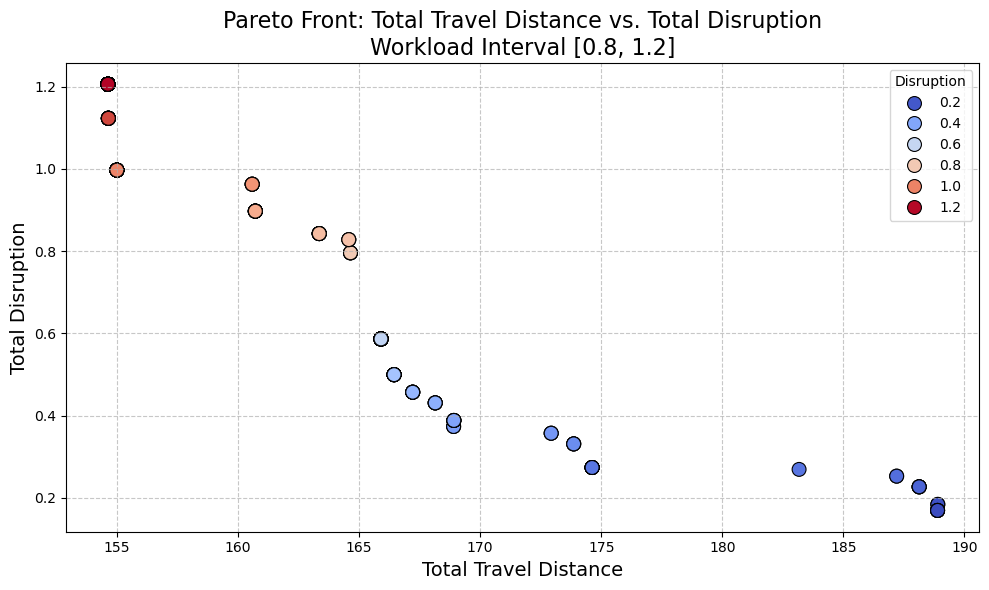

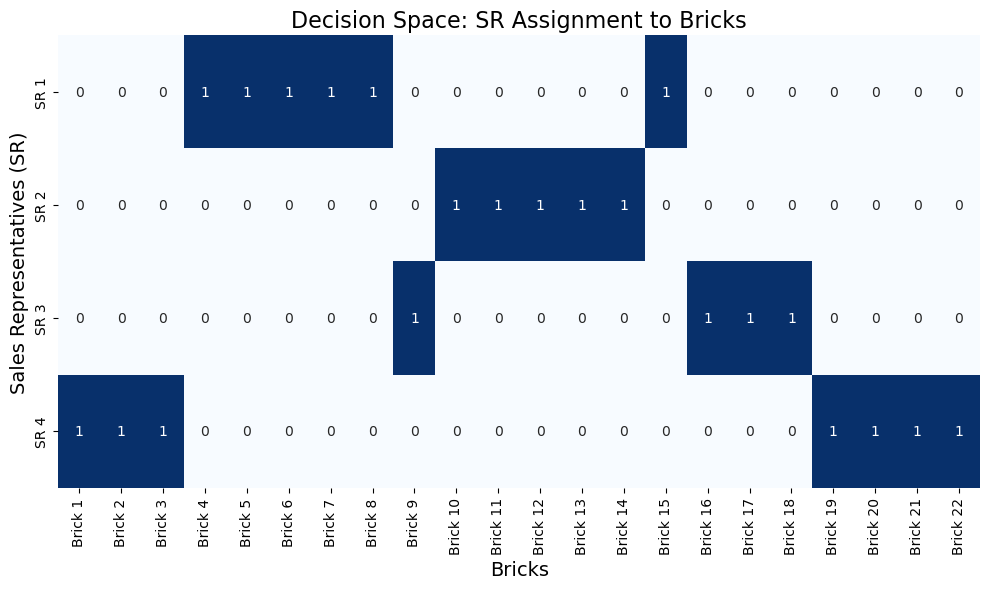

Solving for workload interval [0.85, 1.15]...


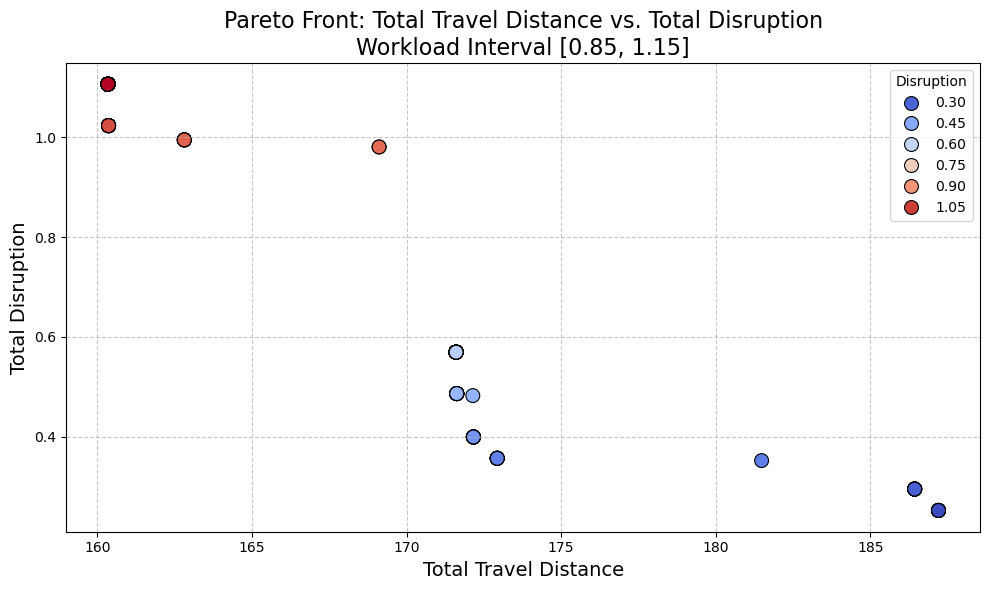

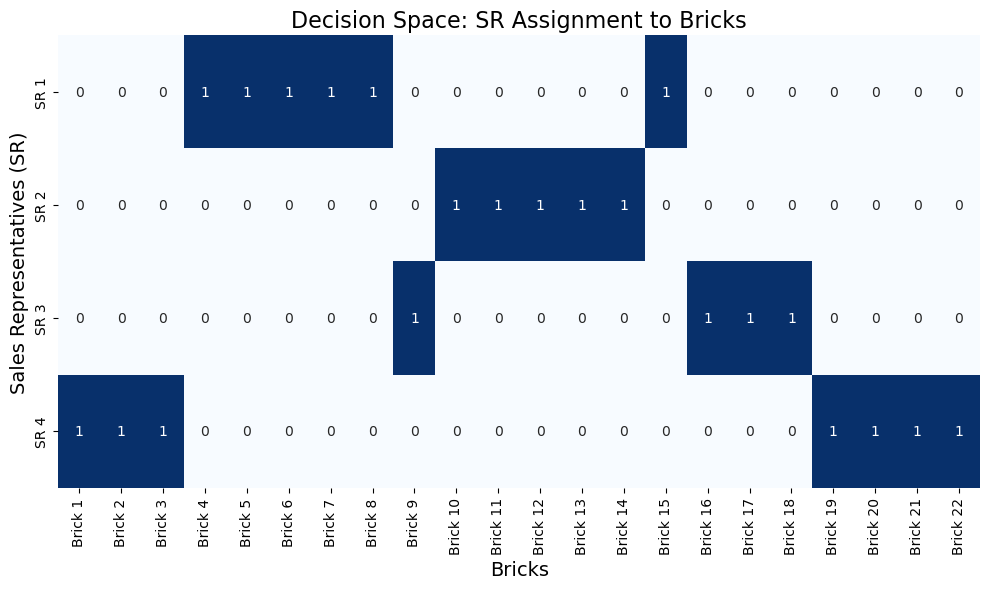

Solving for workload interval [0.9, 1.1]...


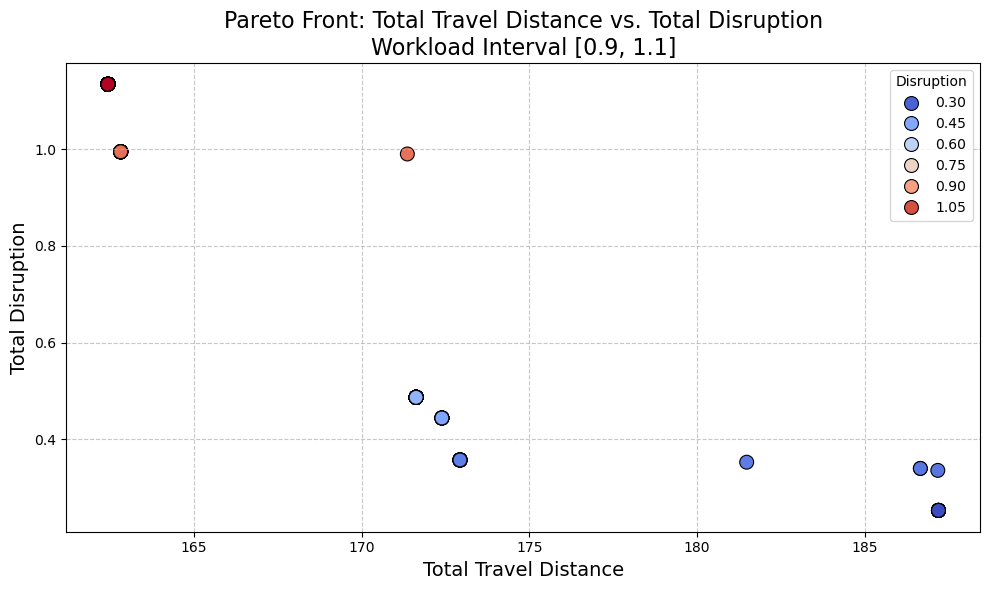

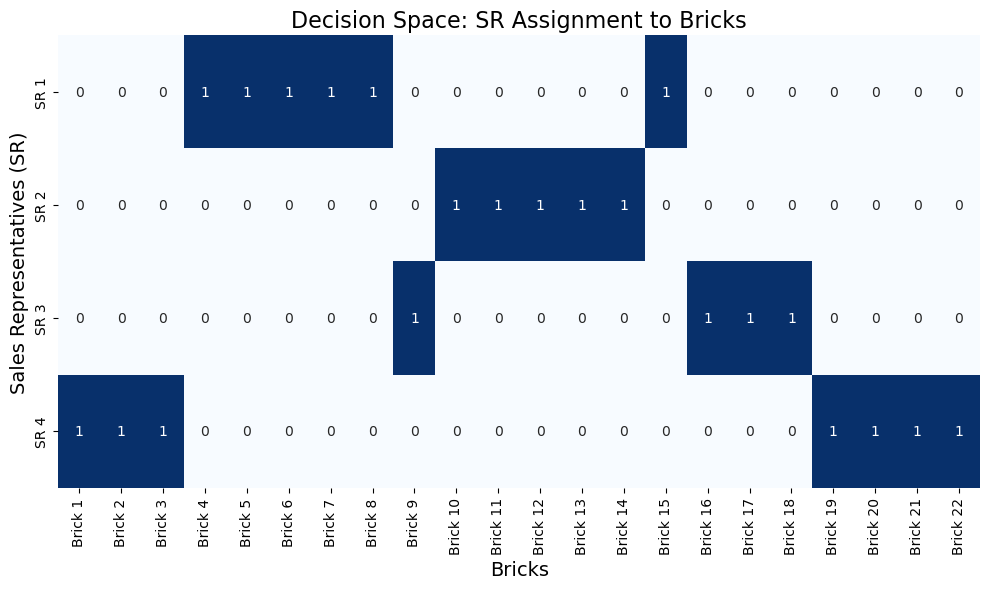

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Epsilon-constraint method to generate Pareto Front
def epsilon_constraint_method(distances, workloads, assigned_matrix, min_workload, max_workload, epsilon_values):
    non_dominated_solutions = []

    # Solve for different epsilon values (for disruption)
    for epsilon in epsilon_values:
        model = Model("Epsilon_Constraint")
        model.setParam('OutputFlag', 0)  # Suppress output
        
        assignment_vars = model.addVars(n, m, vtype=GRB.BINARY, name="x")

        # Minimize travel distance
        model.setObjective(
            quicksum(distances[sr][brick] * assignment_vars[sr, brick] for sr in range(n) for brick in range(m)),
            GRB.MINIMIZE
        )

        # Add workload and disruption constraints
        add_common_constraints(model, assignment_vars, workloads, min_workload, max_workload)
        model.addConstr(
            quicksum(workloads[brick] * (1 - assigned_matrix[sr][brick]) * assignment_vars[sr, brick] 
                     for sr in range(n) for brick in range(m)) <= epsilon
        )

        # Optimize the model
        model.optimize()

        if model.status == GRB.OPTIMAL:
            travel_distance = model.objVal
            disruption = sum(workloads[brick] * (1 - assigned_matrix[sr][brick]) * 
                             model.getVarByName(f"x[{sr},{brick}]").x for sr in range(n) for brick in range(m))
            non_dominated_solutions.append((travel_distance, disruption))

    return non_dominated_solutions

# Visualization of the Pareto Front using Seaborn
def plot_non_dominated_solutions(non_dominated_solutions, lower, upper):
    travel_distances, disruptions = zip(*non_dominated_solutions)

    # Convert data to a pandas DataFrame for better plotting control
    data = pd.DataFrame({
        'Travel Distance': travel_distances,
        'Disruption': disruptions
    })

    plt.figure(figsize=(10, 6))

    # Use seaborn's scatterplot for better aesthetics
    sns.scatterplot(data=data, x='Travel Distance', y='Disruption', 
                    hue='Disruption', palette='coolwarm', s=100, edgecolor='black')

    # Plot styling improvements
    plt.title(f"Pareto Front: Total Travel Distance vs. Total Disruption\nWorkload Interval [{lower}, {upper}]", fontsize=16)
    plt.xlabel("Total Travel Distance", fontsize=14)
    plt.ylabel("Total Disruption", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visual representation of the decision space
def plot_decision_space(assignment_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(assignment_matrix, cmap="Blues", annot=True, fmt="d", cbar=False, 
                xticklabels=[f"Brick {i+1}" for i in range(m)], yticklabels=[f"SR {i+1}" for i in range(n)])
    plt.title("Decision Space: SR Assignment to Bricks", fontsize=16)
    plt.xlabel("Bricks", fontsize=14)
    plt.ylabel("Sales Representatives (SR)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Main workflow to solve for different workload intervals
def solve_for_intervals():
    # Load data
    distances, workloads = load_data()

    # Initialize matrix and workload limits
    assigned_matrix, assigned_bricks = initialize_assigned_bricks()

    # Define epsilon values for disruption constraint
    epsilon_values = np.linspace(0, 1.5 * sum(workloads), 1000)

    # Test for different workload intervals
    intervals = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

    for lower, upper in intervals:
        print(f"Solving for workload interval [{lower}, {upper}]...")
        min_workload, max_workload = set_workload_limits(workloads, lower, upper)
        
        # Get the non-dominated solutions using epsilon-constraint
        non_dominated_solutions = epsilon_constraint_method(distances, workloads, assigned_matrix, min_workload, max_workload, epsilon_values)
        
        # Plot the Pareto front for this interval
        plot_non_dominated_solutions(non_dominated_solutions, lower, upper)
        
        # Plot the decision space for this interval (visual representation of assignments)
        plot_decision_space(assigned_matrix)

# Run the solution process
solve_for_intervals()
